# Future Ecological Index plots
- Plot future ecological index
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- October 2024

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import colors as c
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Load EcoIndex Data

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

### Load Decadal index

In [7]:
file_in = 'ecoindex_historical_future.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

# mask land
ds_eco = ds_eco.where(ds_grid.REGION_MASK == 1)

In [8]:
# keep only regional data
eco_decade = ds_eco.ecoindex_regional_decadal

### Load the typical polynya data

In [9]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [10]:
# Read in jra55 polynya data
file_in = 'CESM_grid_CESM2-LE_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_typical = ds_poly.polynya_typical_all_hi

## Load map related files

### Load regional masks

In [11]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [12]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


### Load shapefiles

In [13]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [14]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

In [15]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [16]:
# Read in CCAMLR MPA files

# Adopted mpas
file_in = 'CCAMLR_MPAs/RossSea_no_ice_shelf/2015CCAMLR_RossSeaMore_102020.shp'
shdf_ross = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ross = shdf_ross.to_crs(ccrs.SouthPolarStereo())

# Proposed Weddell
file_in = 'CCAMLR_MPAs/WSMPA2019_Shapefile/WSMPA2019.shp'
shdf_wed = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_wed = shdf_wed.to_crs(ccrs.SouthPolarStereo())

# Proposed Weddell Phase 2
file_in = 'CCAMLR_MPAs/WSMPAP2_polygons/OuterBoundary.shp'
shdf_wed2 = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_wed2 = shdf_wed2.to_crs(ccrs.SouthPolarStereo())

# Proposed E. Antarctica
file_in = 'CCAMLR_MPAs/Earsmpa_2015_CCAMLR_XXXIV/Earsmpa_2015_CCAMLR_XXXIV.shp'
shdf_eant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_eant = shdf_eant.to_crs(ccrs.SouthPolarStereo())

# Proposed Peninsula
file_in = 'CCAMLR_MPAs/D1MPA_Vertices_2024_HS/D1MPA_Vertices_2024_HS_cut.shp'
shdf_pen = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_pen = shdf_pen.to_crs(ccrs.SouthPolarStereo())

## Make masks of "very high" and "high" region

- Very high: EI>= 0.8
- High: EI>=0.6 AND EI<0.8
- Moderate: EI>=0.4 AND EI<0.6
- Low: EI<0.4

In [17]:
#eco_bin_names = ['very_high','high','moderate','low']
eco_bin_names = [1,2,3,4]

In [18]:
# combine these into a single array
xlen = len(ds_eco.nlon)
ylen = len(ds_eco.nlat)
dlen = len(ds_eco.decades)

In [19]:
# decadal masking
data = eco_decade

# make arrays to fill
eco_1 = data.where(data == 1, other =1)
eco_2 = data.where(data == 1, other =1)
eco_3 = data.where(data == 1, other =1)
eco_4 = data.where(data == 1, other =1)

# now just mask by bin
eco_1 = eco_1.where(data >=0.8)
eco_2 = eco_2.where((data >=0.6) & (data <0.8))
eco_3 = eco_3.where((data >=0.4) & (data <0.6))
eco_4 = eco_4.where(data <0.4)

# convert to single array
eco_bins = np.zeros([4,dlen,ylen,xlen])
eco_bins[0,:,:,:] = eco_1.values
eco_bins[1,:,:,:] = eco_2.values
eco_bins[2,:,:,:] = eco_3.values
eco_bins[3,:,:,:] = eco_4.values

# convert to xarray
eco_bins = xr.DataArray(eco_bins,dims=('bins','decades','nlat','nlon'))
eco_bins['bins'] = data.decades
eco_bins['decades'] = data.decades
eco_bins['nlat'] = data.nlat
eco_bins['nlon'] = data.nlon

### Analysis of high and very high regions

In [20]:
# decadal masking - VERY HIGH & HIGH together
data = eco_decade

# make arrays to fill
eco_1 = data.where(data == 1, other =1)

# now just mask by bin
eco_bins_high = eco_1.where(data >=0.6)

# mask land
eco_bins_high = eco_bins_high.where(ds_grid.REGION_MASK == 1)

In [21]:
# just analyze from 2000-2090
eco_bins_high_sub = eco_bins_high.where(eco_bins_high.decades >= 2000, drop=True)

In [22]:
# calculate how many decades are highly valuable
frac_high = eco_bins_high_sub.sum(dim='decades')

# mask land
frac_high = frac_high.where(ds_grid.REGION_MASK == 1)

In [23]:
# calculate total area this highly valuable per region
area_high = eco_bins_high_sub * ds_grid.TAREA

# get it into regions
area_high_reg = area_high * ccamlr_masks
# now sum over lat/lon
area_high_reg_sum = area_high_reg.sum(dim=["nlat","nlon"])
# now convert from cm2 to km2
area_high_reg_sum = area_high_reg_sum/(100*100*1000*1000)
# now convert to millions of km2
area_high_reg_sum = area_high_reg_sum/1000000

## Plot figures

In [24]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_4/'

In [25]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [26]:
# get colony distance info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

### Set plotting ranges, etc.
- All EcoIndex values go from 0 to 1

In [27]:
# set some plotting info
cmap_in = cmocean.cm.rain
vmin_in = 0.0
vmax_in = 1.0
# set contour levels
levels_in_dec = np.arange(0,11,1)
levels_in_poly = np.arange(0,3,1)
levels_in_ctr = np.arange(0,3,1)
units = ' '
title = 'EcoIndex Values'

### Plot Fraction of time a cell is "very high" or "high" ecoindex

In [32]:
fout = 'Figure_3_Ecoindex_regional_future_num_decades'
# get data to plot
data_plt = frac_high

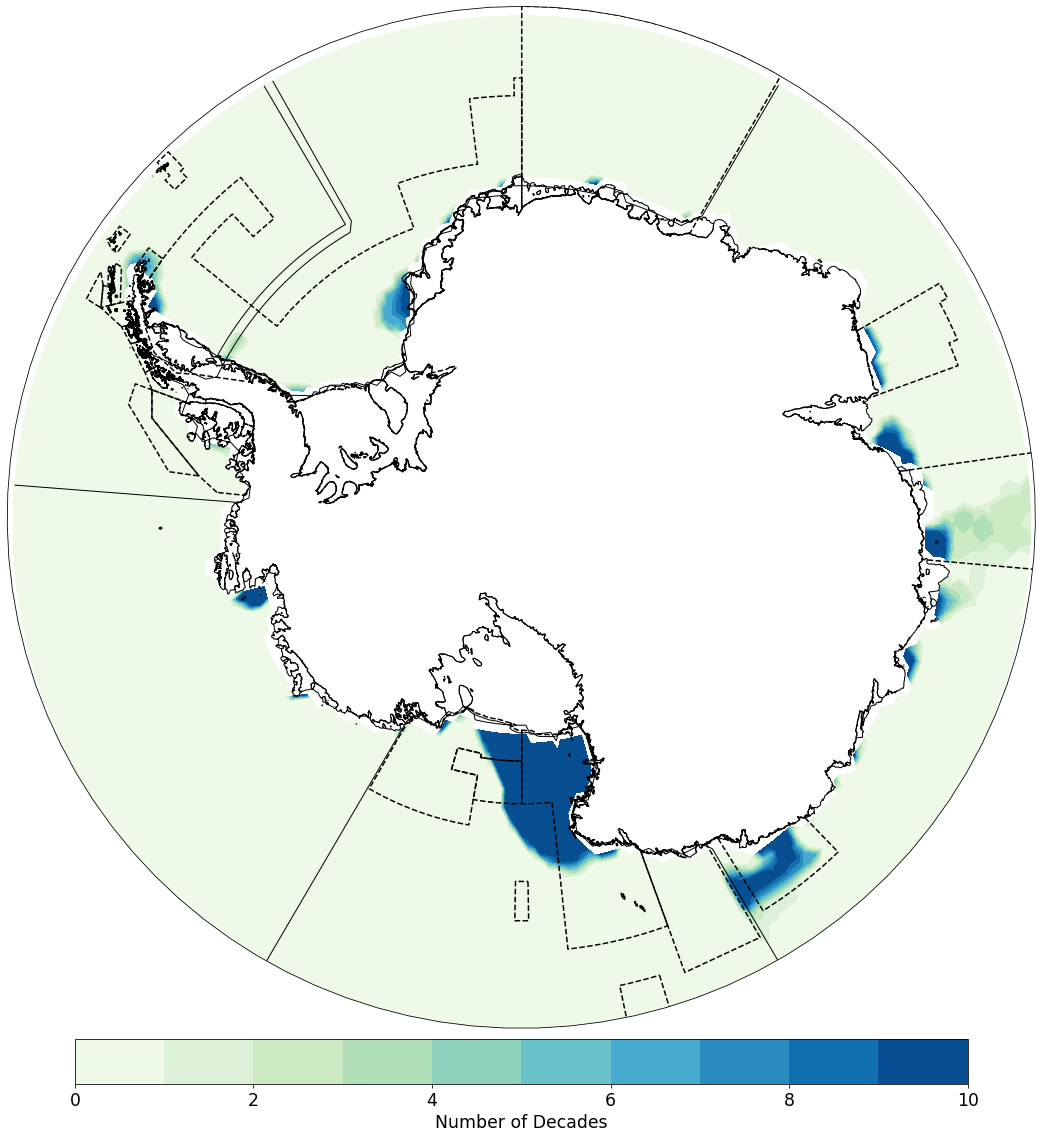

In [33]:
# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Add CCAMLR MPA regions
ax.add_geometries(shdf_ross.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1.5,linestyle='dashed')
ax.add_geometries(shdf_wed.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1.5,linestyle='dashed')
ax.add_geometries(shdf_wed2.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1.5,linestyle='dashed')
ax.add_geometries(shdf_eant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1.5,linestyle='dashed')
ax.add_geometries(shdf_pen.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1.5,linestyle='dashed')

### Add regional domain lines
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_1_mod').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree())
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=1,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

### Plot Number of decades point is high or very high
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.contourf(lon,lat,field,
                 cmap="GnBu",                      
                 levels=levels_in_dec,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('Number of Decades',fontsize='xx-large')

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
#fig.suptitle(title,fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)